In [1]:
import numpy as np
from astropy.table import Table, vstack, hstack, Column
import os, sys, math, pdb, glob, fnmatch
import astropy.units as u
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import ligo.skymap.plot
from scipy.stats import norm
import scipy.stats

import gcn
import gcn.handlers
import gcn.notice_types
import requests
import healpy as hp
#plt.style.use('classic')


In [2]:
#load in CLU catalog
clu=Table.read('LIGOcross/CLU_20170106_galexwise_DaveUpdate.fits')
clucoord=SkyCoord(ra=clu['RA']*u.deg,dec=clu['DEC']*u.deg)
nclu=np.size(clu)

#sky localization colmns to the galaxy catalog: probability density and p-value per volume and per area.
probdencol=Column(np.zeros(nclu,dtype='f4'),name='dP_dV')
probcol=Column(np.zeros(nclu,dtype='f4'),name='P')
probdenAcol=Column(np.zeros(nclu,dtype='f4'),name='dP_dA')
probAcol=Column(np.zeros(nclu,dtype='f4'),name='P_A')
clu.add_columns([probdencol,probcol,probdenAcol,probAcol])


In [3]:
#load in healpix map
prob,distmu,distsigma,distnorm=hp.read_map('LIGOcross/GW170817_prelim.fits.gz',field=[0,1,2,3],dtype=('f8','f8','f8','f8'))
npix=len(prob)
nside=hp.npix2nside(npix)
pixarea=hp.nside2pixarea(nside)

#calc hp index for each galaxy
theta=0.5 * np.pi - clucoord.dec.to('rad').value
phi=clucoord.ra.to('rad').value
ipix=hp.ang2pix(nside,theta,phi)


NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


In [4]:
#get coord of max prob density for plotting purposes
#ipix_max=np.where(prob == np.max(prob))
ipix_max = np.argmax(prob)
theta_max, phi_max = hp.pix2ang(nside, ipix_max)
ra_max = np.rad2deg(phi_max)
dec_max = np.rad2deg(0.5 * np.pi - theta_max)
center = SkyCoord(ra=ra_max*u.deg,dec=dec_max*u.deg)



/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]


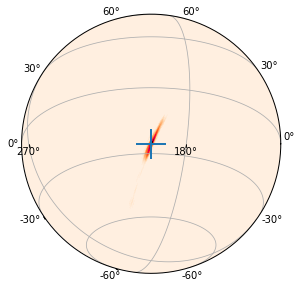

In [5]:
#plot up the sky localization and overplot the galaxies
#give the students most of this. Later they will have to add to it in order to overplot the galaxies
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax.grid()
ax.imshow_hpx('LIGOcross/GW170817_prelim.fits.gz', cmap='cylon')
ax.plot(
    center.ra.deg, center.dec.deg,
    transform=ax.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=30,
    markeredgewidth=2)
plt.show()

In [6]:
#calc probability density per area on the sky for each galaxy
#Have them figure out dp_da, but help them a bit for the radial and volume calculation. 
#maybe point them to Leo's 2016 supplement paper???
dp_dA=prob[ipix]/pixarea
clu['dP_dA']=dp_dA

#probability along radial distance
dp_dr=clu['DISTMPC']**2 * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['DISTMPC'])

#calc probability density per volume for each galaxy
dp_dV=prob[ipix] * distnorm[ipix] * norm(distmu[ipix],distsigma[ipix]).pdf(clu['DISTMPC'])/pixarea 
clu['dP_dV']=dp_dV


#for sanity check against Leo's numbers during the actual event
#ind=np.where(clu['NAME'] == 'PGC45657                      ') #n4993
#print('dp_dr = %f' %dp_dr[ind])  #per steradian
#print('dp_dA = %f' %dp_dA[ind])
#print(ind)
#print('dp_dV = %f' %clu['dP_dV'][ind])
#print('    P = %f' %clu['P'][ind])



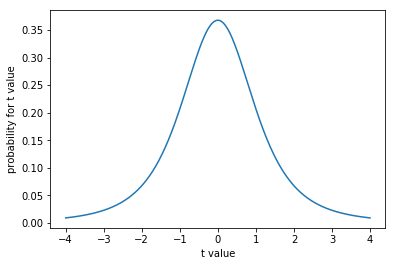

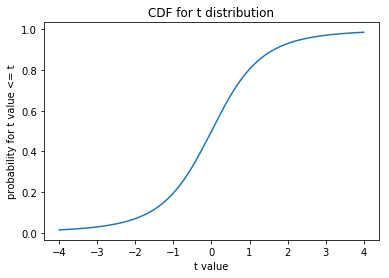

In [7]:
#perhaps have them go through a simple example of how p-values are calculated, 
#then have them apply this to the LIGO-galay prob densities


#Imagine I have a t statistic with 3 degrees of freedom.
#Scipy provides a t distribution class that we can use to get values from 
#the t statistic probability density function (PDF).
#As a start, we plot the PDF for a t statistic with 3 degrees of freedom:

# Make a t distribution object for t with 3 degrees of freedom
t_dist = scipy.stats.t(3)
# Plot the PDF
t_values = np.linspace(-4, 4, 1000)
plt.plot(t_values, t_dist.pdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value')
plt.show()

#The t distribution object t_dist can also give us the cumulative distribution function (CDF). 
#The CDF gives the area under the curve of the PDF at and to the left of the given t value:

plt.plot(t_values, t_dist.cdf(t_values))
plt.xlabel('t value')
plt.ylabel('probability for t value <= t')
plt.title('CDF for t distribution')
plt.show()

#Say I have a t value x drawn from a t distribution with 20 degrees of freedom. 
#The PDF gives the probability for given values of x. Because it is a probability density, 
#the sum of the probabilities of all possible values for x: ∞<x<∞ must be 1. 
#Therefore the total area under the PDF curve is 1, and the maximum value of the CDF is 1.

#The CDF gives us the area under the PDF curve at and to the left of a given t value x. 
#Therefore it is the probability that we will observe a value x<=t if we sample a value x 
#from a t distribution of (here) 20 degrees of freedom.




0.11529193262241144

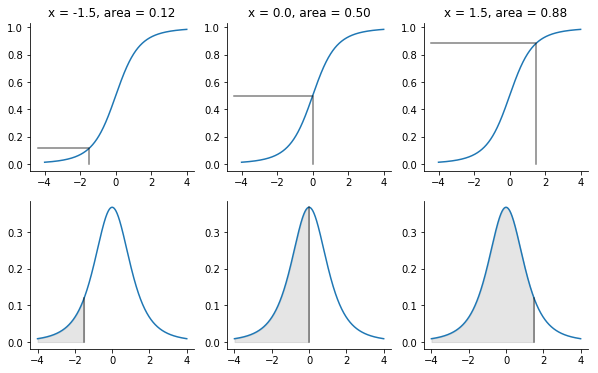

In [8]:
# Show relationship of PDF and CDF for three example t values.
#give the students most of the code for these plots
example_values = (-1.5, 0, 1.5)
pdf_values = t_dist.pdf(t_values)
cdf_values = t_dist.cdf(t_values)
fill_color = (0, 0, 0, 0.1)  # Light gray in RGBA format.
line_color = (0, 0, 0, 0.5)  # Medium gray in RGBA format.
fig, axes = plt.subplots(2, len(example_values), figsize=(10, 6))
for i, x in enumerate(example_values):
    cdf_ax, pdf_ax = axes[:, i]
    cdf_ax.plot(t_values, cdf_values)
    pdf_ax.plot(t_values, pdf_values)
    # Fill area at and to the left of x.
    pdf_ax.fill_between(t_values, pdf_values,
                        where=t_values <= x,
                        color=fill_color)
    pd = t_dist.pdf(x)  # Probability density at this value.
    # Line showing position of x on x-axis of PDF plot.
    pdf_ax.plot([x, x],
                [0, pd], color=line_color)
    cd = t_dist.cdf(x)  # Cumulative distribution value for this x.
    # Lines showing x and CDF value on CDF plot.
    x_ax_min = cdf_ax.axis()[0]  # x position of y axis on plot.
    cdf_ax.plot([x, x, x_ax_min],
                [0, cd, cd], color=line_color)
    cdf_ax.set_title('x = {:.1f}, area = {:.2f}'.format(x, cd))
    # Hide top and right axis lines and ticks to reduce clutter.
    for ax in (cdf_ax, pdf_ax):
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
#For example, say I have drawn a t value x at random from a t distribution 
#with 20 degrees of freedom. The probability that x<=1.5 is:

# Area of PDF at and to the left of 1.5
t_dist.cdf(1.5)
#>0.9253...

#The total area under the PDF is 1, and the maximum value for the CDF is 1. 
#Therefore the area of the PDF to the right of 1.5 must be:

# Area of PDF to the right of 1.5
1 - t_dist.cdf(1.5)
#>0.0746...

#This is the probability that our t value x will be >1.5. 
#In general, when we sample a value x at random from a t distribution, 
#the probability that x>q is given by:

#ℙ(x>q)=1−CDF(q)
#where CDF is the cumulative distribution function for a t value.


#have the students fill out the example for 90% or something



In [9]:

#use normalized cumulative dist function to calculate Area P-value for each galaxy

clu.sort('dP_dA')
clu.reverse()
cum_sort=np.cumsum(clu['dP_dA'])
cumnorm_sort=cum_sort/np.max(cum_sort)
clu['P_A']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icutarea90=np.where(clu['P_A'] <= 0.9)
clucutarea90=clu[icutarea90]
clucutarea90coord=SkyCoord(ra=clucutarea90['RA']*u.deg,dec=clucutarea90['DEC']*u.deg)

print('# of galaxies in 90%% Area = %i' %(np.size(icutarea90)))

#sort the galaxies by Stellar Mass,then print list of prioritized galaxies
clucutarea90.sort('MSTAR')
clucutarea90.reverse()
#clucutarea90['NAME','MSTAR','dP_dV','P'].pprint(max_lines=100)

# of galaxies in 90% Area = 854


/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]


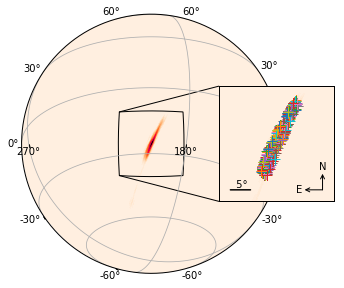

In [10]:
#area
#plot up the sky localization and overplot the galaxies
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=15*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx('LIGOcross/GW170817_prelim.fits.gz', cmap='cylon')
ax_inset.imshow_hpx('LIGOcross/GW170817_prelim.fits.gz', cmap='cylon')
for coord in clucutarea90coord:
    ax_inset.plot(
    coord.ra.deg, coord.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=1)
plt.show()



#point = why distance/volume is important...


In [11]:
#use normalized cumulative dist function to calculate Volume P-value for each galaxy
clu.sort('dP_dV')
clu.reverse()
cum_sort=np.cumsum(clu['dP_dV'])
cumnorm_sort=cum_sort/np.max(cum_sort)
clu['P']=cumnorm_sort

#ID galaxies inside the 90% prob by volume
icut90=np.where(clu['P'] <= 0.9)
clucut90=clu[icut90]
clucut90coord=SkyCoord(ra=clucut90['RA']*u.deg,dec=clucut90['DEC']*u.deg)

print('# of galaxies in 90%% volume = %i' %(np.size(icut90)))

#sort the galaxies by Stellar Mass,then print list of prioritized galaxies
clucut90.sort('MSTAR')
clucut90.reverse()
#clucut90['NAME','MSTAR','dP_dV','P'].pprint(max_lines=100)

#then print list of prioritized galaxies


# of galaxies in 90% volume = 42


/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]
/data/dcook/anaconda2/envs/py3/lib/python3.6/site-packages/astropy/visualization/wcsaxes/grid_paths.py:73: RuntimeWarning: invalid value encountered in greater
  discontinuous = step[1:] > DISCONT_FACTOR * step[:-1]


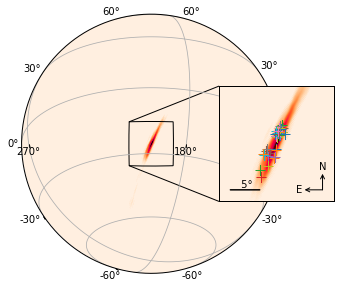

In [12]:
#Volume
#plot up the sky localization and overplot the galaxies
ax = plt.axes(
    [0.05, 0.05, 0.9, 0.9],
    projection='astro globe',
    center=center)

ax_inset = plt.axes(
    [0.59, 0.3, 0.4, 0.4],
    projection='astro zoom',
    center=center,
    radius=10*u.deg)

for key in ['ra', 'dec']:
    ax_inset.coords[key].set_ticklabel_visible(False)
    ax_inset.coords[key].set_ticks_visible(False)
ax.grid()
ax.mark_inset_axes(ax_inset)
ax.connect_inset_axes(ax_inset, 'upper left')
ax.connect_inset_axes(ax_inset, 'lower left')
ax_inset.scalebar((0.1, 0.1), 5 * u.deg).label()
ax_inset.compass(0.9, 0.1, 0.2)

ax.imshow_hpx('LIGOcross/GW170817_prelim.fits.gz', cmap='cylon')
ax_inset.imshow_hpx('LIGOcross/GW170817_prelim.fits.gz', cmap='cylon')
for coord in clucut90coord:
    ax_inset.plot(
    coord.ra.deg, coord.dec.deg,
    transform=ax_inset.get_transform('world'),
    marker=ligo.skymap.plot.reticle(inner=0,outer=1),
    markersize=10,
    markeredgewidth=1)
plt.show()

